# Specific Test III. Learning Mass of Dark Matter Halo
### Task: Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice. Please implement your approach in PyTorch or Keras and discuss your strategy.

### Dataset: [dataset.zip - Google Drive](https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view)

#### Dataset Description: The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided

#### Evaluation Metrics: MSE (mean squared error)

In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 26.3 MB/s 


### Mounting drive to load data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!tar --extract --file '/content/gdrive/MyDrive/ML4SCI/DeepLense/Task3/lens_data_alt.tgz' 

### Importing required libraries

In [4]:
#Utilities
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#Loading image and plotting visualizations/images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

#PyTorch framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

#For pre-trained models
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Creating a custom dataset class

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = glob.glob(root_dir)
        self.transform = transform
        self.data = []

        for img_path in tqdm(self.root_dir):
            self.data.append(img_path)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      img, mass = np.load(self.data[idx], allow_pickle = True)
      mass = torch.tensor(mass, dtype = torch.float)

      if self.transform:
          aug = self.transform(image = img)
          img = aug['image']

      else:
        img = torch.tensor(img, dtype = torch.float)
        img = img.view(-1, 150, 150)

      return img, mass

In [6]:
data_dir = r'/content/lens_data/*'
dataset = CustomDataset(data_dir)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [27]:
dataset[0][0].shape, dataset[0][1].shape, 

(torch.Size([1, 150, 150]), torch.Size([]))

### Splitting data into train and val/test sets

In [9]:
m=len(dataset)
print(m)
try:
    train_set,val_set=random_split(dataset,[int(m-m*0.2),int(m*0.2)])
except:
    train_set,val_set=random_split(dataset,[int(m-m*0.2),int(m*0.2+1)])

print(len(train_set),len(val_set))

20000
16000 4000


In [10]:
#Using a batch size of 128
BS = 128

### Creating data loaders separately for train data and val/test data

In [11]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)

In [12]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([128, 1, 150, 150])

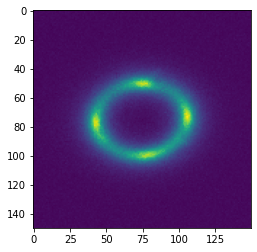

In [13]:
plt.imshow(single_batch[0][0].squeeze())

### Creating model
#### Using the Efficient Net B3 pre-trained model as the backbone, adding some linear layers and output layer having 1 neuron (for single continuous value output, i.e halo mass) and fine-tuning to this dataset

In [14]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b3',pretrained = pretrained, in_chans = 1)
#        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1536 * 5 * 5, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.3),
        
                                nn.Linear(1024, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),                                
                                nn.Linear(128, 1)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1536 * 5 * 5)
        x = self.fc(x)
        return x

In [16]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        y_pred = y_pred.view(-1)
        #loss calculation
        loss = criterion(y_pred, y_truth)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return model, np.mean(train_loss)

In [17]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)
            y_pred = y_pred.view(-1)

            #loss calculation
            loss = criterion(y_pred, y_truth)

            #batch loss
            val_loss.append(loss.detach().cpu().numpy())
            
    return np.mean(val_loss)

In [18]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = val_epoch(model, val_loader, criterion)

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)


    return model, loss_dict

### Initializing the model and deciding the hyperparameter values

##### Multi-class classification problem -> Loss function : MSE Loss
##### Model trained for 20 epochs
##### Adam Optimizer used with learning rate 3e-4

In [19]:
model = pre_trained_model().to(device)

criterion = nn.MSELoss()
EPOCHS = 20
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [20]:
#Training model
model, loss_dict = fit_model(model,criterion,optimizer)

Epoch 1/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.10931593924760818, Val loss:0.0031803324818611145
Epoch 2/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.00464787008240819, Val loss:0.0013860384933650494
Epoch 3/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.002824680181220174, Val loss:0.0009903997415676713
Epoch 4/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.002029719529673457, Val loss:0.0006777773378416896
Epoch 5/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0015527753857895732, Val loss:0.0006859954446554184
Epoch 6/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0012102831387892365, Val loss:0.0005454362253658473
Epoch 7/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0010574314510449767, Val loss:0.0004261158173903823
Epoch 8/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0008819451322779059, Val loss:0.0005217720754444599
Epoch 9/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0007636900991201401, Val loss:0.00038330600364133716
Epoch 10/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0006605213275179267, Val loss:0.00034083446371369064
Epoch 11/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.000601499225012958, Val loss:0.0002857264189515263
Epoch 12/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0005389787838794291, Val loss:0.0002905217988882214
Epoch 13/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0004726600309368223, Val loss:0.00026748969685286283
Epoch 14/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0005052283522672951, Val loss:0.00025999543140642345
Epoch 15/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0004469742125365883, Val loss:0.0002916303346864879
Epoch 16/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0004280482535250485, Val loss:0.0002504029544070363
Epoch 17/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.00036825399729423225, Val loss:0.00030027423053979874
Epoch 18/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0003440403379499912, Val loss:0.0002687510568648577
Epoch 19/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.0003164509544149041, Val loss:0.0002971517969854176
Epoch 20/20:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Train loss:0.00032418681075796485, Val loss:0.00026042546960525215


### Reduction of train and test MSE loss with training

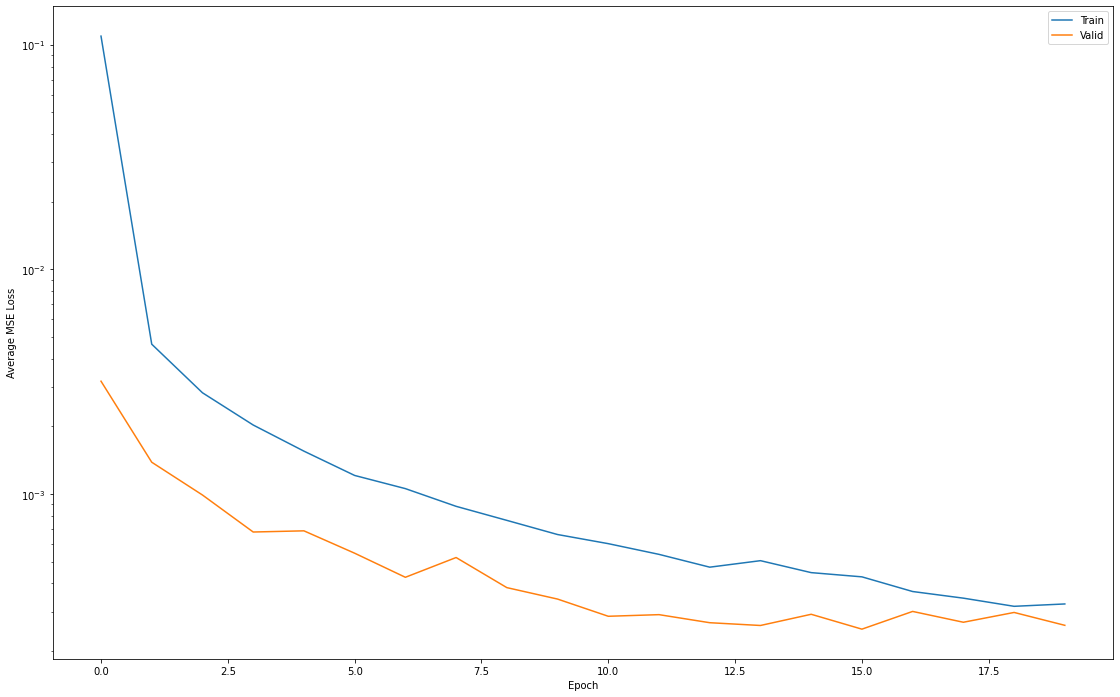

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot losses
plt.figure(figsize=(19,12))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()
plt.savefig("Loss_history.png")

In [23]:
PATH = "efficient_netB3_finetuned.pth"
torch.save(model.state_dict(), PATH)